In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2024-05-21 10:47:22.701744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 10:47:22.701869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 10:47:22.804653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes/train.csv')
df_val = pd.read_csv('/kaggle/input/dataframes/val.csv')
df_test = pd.read_csv('/kaggle/input/dataframes/val.csv')

# load visual embeddings
with open('/kaggle/input/v-embeds/v_embeds_train.pkl', 'rb') as f:
    v_embeds_train = pickle.load(f) 
    
with open('/kaggle/input/v-embeds/v_embeds_val.pkl', 'rb') as f:
    v_embeds_val = pickle.load(f) 
    
with open('/kaggle/input/v-embeds/v_embeds_test.pkl', 'rb') as f:
    v_embeds_test = pickle.load(f) 

In [3]:
print(len(v_embeds_train))
print(v_embeds_train[0].shape)
stacked_tensor = torch.stack(v_embeds_train, dim=0)

print(stacked_tensor.shape)

1962
torch.Size([100, 1024])
torch.Size([1962, 100, 1024])


In [4]:
# stack visual features 
X_train = torch.stack(v_embeds_train, dim=0).cpu().numpy()
X_val = torch.stack(v_embeds_val, dim=0).cpu().numpy()
X_test = torch.stack(v_embeds_test, dim=0).cpu().numpy()
print(X_train.shape, X_val.shape, X_test.shape)

(1962, 100, 1024) (109, 100, 1024) (109, 100, 1024)


In [5]:
# convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['AUTHOR']) # RICHTIG SO??? fit und dann transform?
y_val = label_encoder.transform(df_val['AUTHOR'])
y_test = label_encoder.transform(df_test['AUTHOR'])

In [9]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4) # decreased learning rate from 1e-5 to 1e-3, maybe 1e-4 is better
#loss_func = tf.keras.losses.CategoricalCrossentropy() # BERT USES this! Maybe change labels!!!
#acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val)) # like in BERT batch size = 16

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


#test_predictions = model.predict(X_test)
#model.save("baseline_model.h5")

Epoch 1/10
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1058 - loss: 39.8691

W0000 00:00:1716288550.373397     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1368 - loss: 31.6341

W0000 00:00:1716288552.966421     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.1385 - loss: 31.2585 - val_accuracy: 0.2752 - val_loss: 4.3109
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5083 - loss: 2.1079 - val_accuracy: 0.2661 - val_loss: 3.4248
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8180 - loss: 0.5612 - val_accuracy: 0.3028 - val_loss: 2.8552
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9469 - loss: 0.2168 - val_accuracy: 0.3119 - val_loss: 3.1410
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9941 - loss: 0.0878 - val_accuracy: 0.3303 - val_loss: 2.9715
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9995 - loss: 0.0477 - val_accuracy: 0.2844 - val_loss: 3.0430
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0307 - val_accuracy: 0.3486 - val_loss: 3.1084
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0209 - val_accuracy: 0.3394 - val_loss: 

W0000 00:00:1716288558.935509     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3123 - loss: 3.1726
Validation Loss: 3.142831802368164, Validation Accuracy: 0.3302752375602722
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1927 - loss: 5.5516 
Test Loss: 5.465328216552734, Test Accuracy: 0.19266055524349213


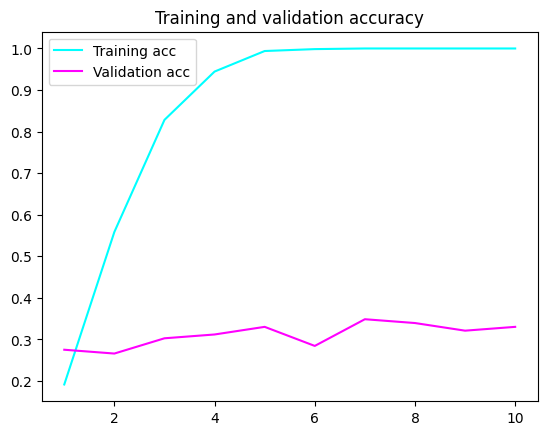

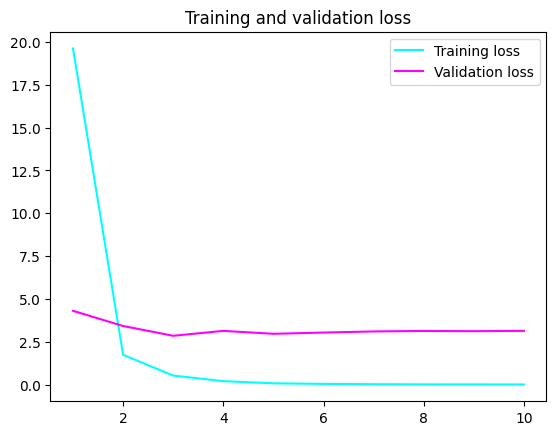

In [11]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model is clearly overfitting (plateau in validation accuracy and loss while the training loss decreases to 0 and the training accuracy reaches 1.0). Data size is relatively small and model might be too complex for this amount of data. Attempt to mitigate this: 

Epoch 1/50
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1294 - loss: 3.4182

W0000 00:00:1716288860.026413     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1555 - loss: 3.2116

W0000 00:00:1716288864.790628     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.1566 - loss: 3.2044 - val_accuracy: 0.2477 - val_loss: 4.9470
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3184 - loss: 2.2539 - val_accuracy: 0.3211 - val_loss: 3.0957
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3726 - loss: 1.9975 - val_accuracy: 0.2661 - val_loss: 2.5513
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4359 - loss: 1.6658 - val_accuracy: 0.2110 - val_loss: 2.5257
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5143 - loss: 1.4570 - val_accuracy: 0.2752 - val_loss: 2.5673
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5695 - loss: 1.2951 - val_accuracy: 0.3211 - val_loss: 2.1927
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6204 - loss: 1.1261 - val_accuracy: 0.2294 - val_loss: 2.3117
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6379 - loss: 1.0436 - val_accuracy: 0.3119 - val_loss: 

W0000 00:00:1716288872.010118     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3008 - loss: 1.9647
Validation Loss: 1.991011142730713, Validation Accuracy: 0.31192660331726074
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1259 - loss: 3.0897 
Test Loss: 3.052583694458008, Test Accuracy: 0.15596330165863037


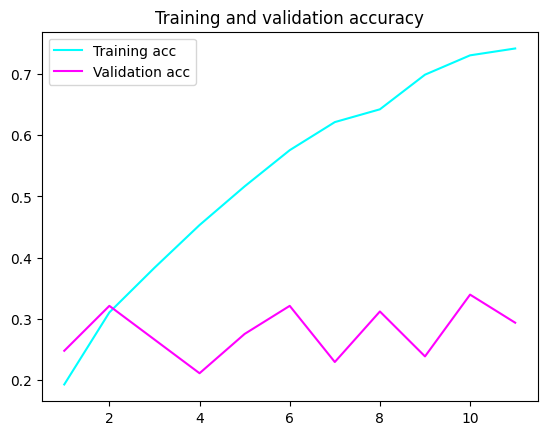

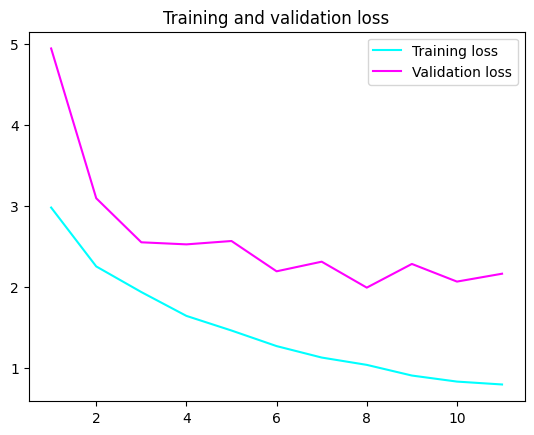

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the model with Dropout and Batch Normalization
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100, 1024)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Only some improvements...